# Введение

Проект посвящён прогнозированию спроса: с целью привлечения большего количества водителей в период пиковой нагрузки нужно спрогнозировать количество заказов такси на следующий час в аэроопрту.

В распоряжении исторические данные. Количество заказов находится в столбце num_orders.

В качестве метрики используется RMSE, пороговое значение по ТЗ: RMSE на тестовой выборке должно быть не больше 48.

План:
1. Чтение и обзор данны, а также базовая подготовка в анализу
- по необходимости - заполнение пропусков, ресемлирование по часовым интервалам
2. Разбитие ряда на компоненты: тренд сезонность и шум. Поиск закономерностей
3. Обучение моделей:
- добавление новых признаков, обучение моделей: линейной регрессии и модели Lasso
4. Тестирование модели: сравнение обученной модели с константной (медианной) и с предыдущим значением
5. Заключение по проекту


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Чтение-и-обзор-данных" data-toc-modified-id="Чтение-и-обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Чтение и обзор данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-к-обучению-моделей" data-toc-modified-id="Подготовка-данных-к-обучению-моделей-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных к обучению моделей</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Lasso</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></ul></div>

## Технический раздел

In [1]:
#импорты

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_squared_error

In [2]:
#функция для добавления новых признаков
def add_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

## Чтение и обзор данных

Начнём с чтения и обзора данных:

In [3]:
data = pd.read_csv('taxi.csv', index_col='datetime', parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


У нас, о счастье, нет пропусков!
Посмотрим немного на данные:

In [5]:
data = data.sort_index()

In [6]:
print(f'Временной диапазон данных: {data.index.min()} - {data.index.max()}')

Временной диапазон данных: 2018-03-01 00:00:00 - 2018-08-31 23:50:00


С первого марта по 31 августа 2018 года, полгода исторических данных. Немало!

Поскольку наша задача - спрогнозировать количество заказов на следующий час, проведём ресемплирование по часовым интервалам с суммированием значений внутри интервала:

In [7]:
#сохраним исходный ряд
data_nosemple = data
data = data.resample('1H').sum()

Вывод: проведено чтение данных, а также краткий обзор. Пропусков в данных нет. В нашем распоряжении исторические данные о количестве заказов такси за полгода. Проведено ресемплирование данных в соответствии со стоящей задачей.

## Анализ компонент временного ряда

Начнём с того, чтобы разбить ряд на компоненты: тренд сезонность и шум, и построить графики в зависимости от времени:

In [8]:
decomposed = seasonal_decompose(data)

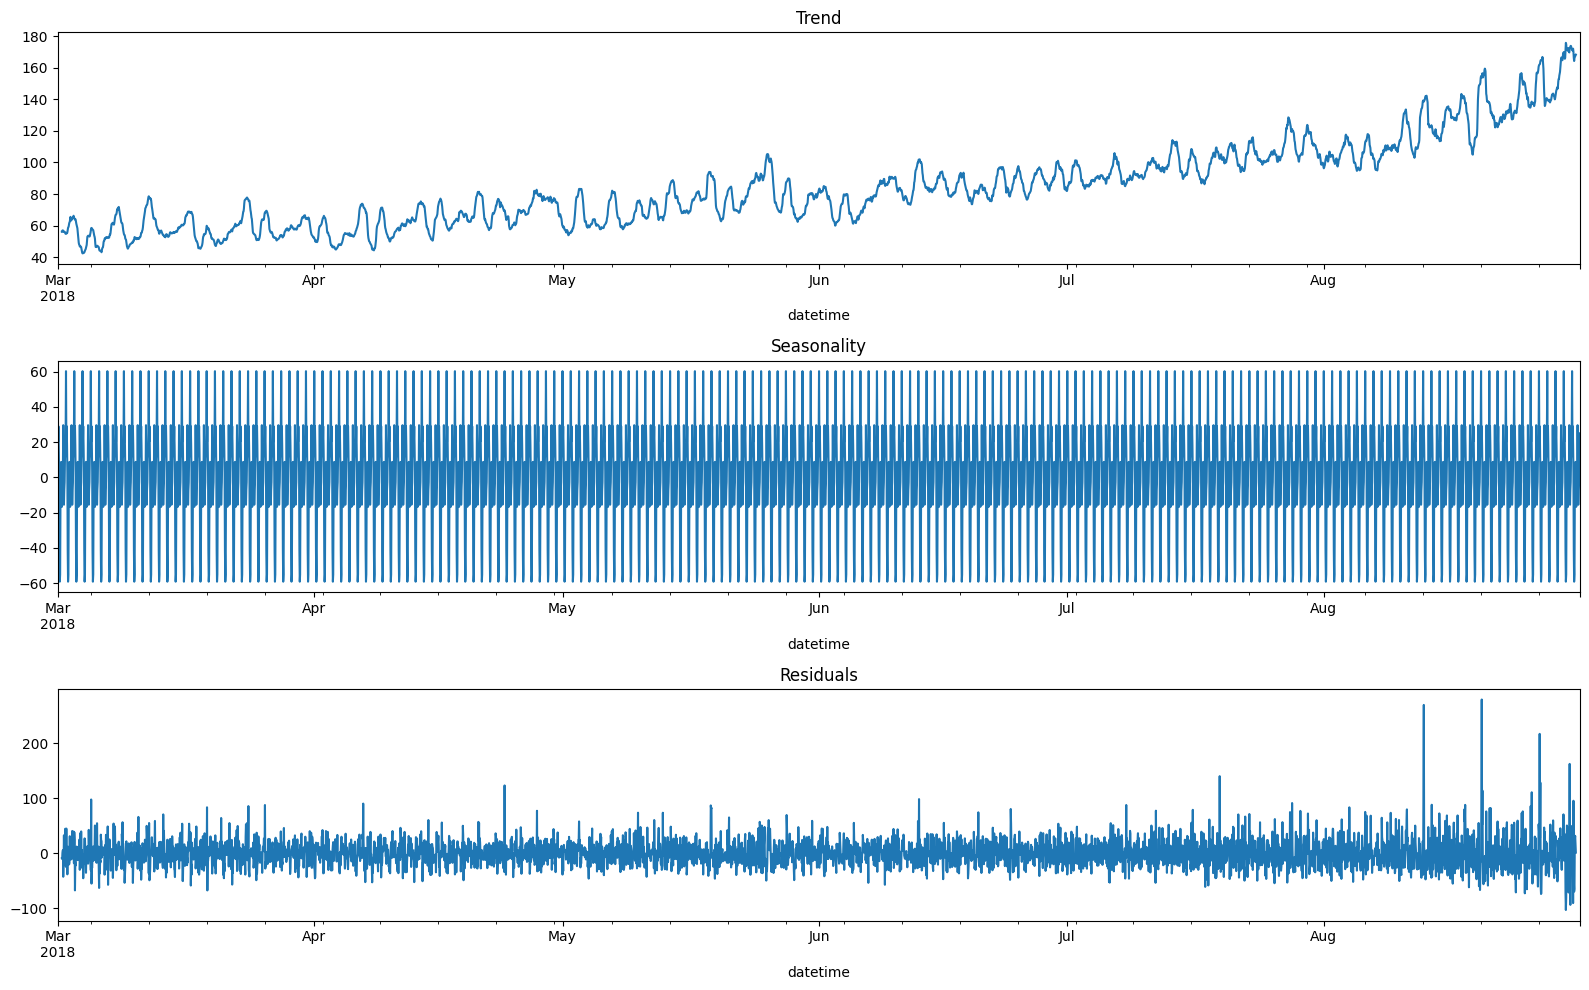

In [9]:
plt.figure(figsize=(16, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

"Сезонность, ты пьяна, иди домой"

- сезонность похожа на стационарный ряд - среднее постоянно, отклонения близки. Ниже посмотрим на уменьшенный интервал для выявления закономерностей
- тренд: количество заказов возрастает с течением времени, зависимость похожа на линейную
- шум имеет постоянное вреднее значение, но явно видны выбросы: вероятно, зповышенной спрос на такси по выходным и праздникам. Амплитуда пиков повышается со временем.


Посмотрим на график сезонности на уменьшенном интервале для обнаружения закономерностей:

Text(0.5, 1.0, 'Seasonality')

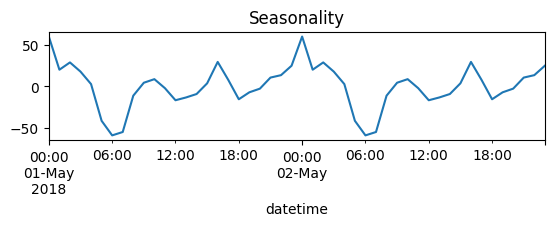

In [10]:
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(ax=plt.gca())
plt.title('Seasonality')

Видно, что количество заказов существенное увеличивается вечером и ночью, спад приходится на раннее утро (6 утра).

Посмотрим на закономерность внутри одной недели:

<Axes: xlabel='datetime'>

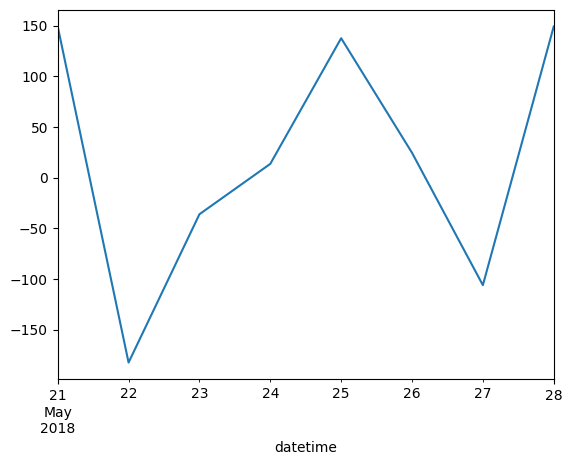

In [11]:
seasonal_decompose(data_nosemple.resample('1D').sum()).seasonal['2018-05-21':'2018-05-28'].plot(ax=plt.gca())

Пик заказов приходится на пятницу и, как ни странно, на понедельник. Резкий спад - во вторник и вечер воскресенья.

## Обучение моделей

Можем переходить к обучению моделей.

### Подготовка данных к обучению моделей

На предыдущем этапе выявили явное наличие дневной сезонности в периоде недели и зависимости от времени суток. С учётом этого создаём новые признаки, которые понадобятся для дальнейшего обучения моделей: час, день, день недели, скользящее среднее, признак отстающего значения.

In [12]:
#значения параментров с учётом выявленных сезонностей
data_modified = add_features(data, 20, 50)
#удаляем строки  с пропусками в lag_i
data_modified = data_modified.dropna()

И разбиваем выборку на обучающую, валидационную и тестовую в соотношении 8:1:1.
Поскольку это временной ряд - важно запретить перемешивание строк.

Сначала откусим тестовую, а потом остальное разобьём на обучающую и валидационную:

In [13]:
train_valid, test = train_test_split(data_modified, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_valid = valid.drop('num_orders', axis = 1)
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

Предварительная подготовка закончена, можем обучать модели.

В качестве метрики будем использовать RMSE - по ТЗ он должен не превышать 48 на тестовой выборке.

### Линейная регрессия

In [14]:
model_lr = LinearRegression().fit(features_train, target_train)

In [15]:
print(f'RMSE на валидационной выборке для модели линейной регрессии = \
    {mean_squared_error(target_valid, model_lr.predict(features_valid)) ** .5}')

RMSE на валидационной выборке для модели линейной регрессии =     37.61452834276079


Неплохо - и даже удовлетворяет условию. Однако посмотрим, получитсяли снизить значение выбранной метрики подбором параметров функции создания признаков - размером максимального смещения и шириной окна:

In [16]:
lag_lr = 0
rolling_lr = 0
rmse_lr = 48
model_lr_best = LinearRegression()

for lag in range(1, 101, 10):
    for roll_size in range(1, 101, 10):
        data_modified = add_features(data, lag, roll_size)
        data_modified = data_modified.dropna()

        train_valid, test = train_test_split(data_modified, shuffle=False, test_size=0.1)
        train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

        features_train = train.drop('num_orders', axis = 1)
        target_train = train['num_orders']
        features_valid = valid.drop('num_orders', axis = 1)
        target_valid = valid['num_orders']
        features_test = test.drop('num_orders', axis = 1)
        target_test = test['num_orders']

        model_lr = LinearRegression().fit(features_train, target_train)
        rmse = mean_squared_error(target_valid, model_lr.predict(features_valid)) ** 0.5

        if rmse < rmse_lr:
            rmse_lr = rmse
            lag_lr = lag
            rolling_lr = roll_size
            model_lr_best = model_lr



In [17]:
print(f'Минимальное RMSE для модели линейной регрессии на валидационной выборке = {rmse_lr}, \
    максимальное смещение = {lag_lr}, размер окна = {rolling_lr}')

Минимальное RMSE для модели линейной регрессии на валидационной выборке = 30.05383778656571,     максимальное смещение = 81, размер окна = 91


С помощью более тщательного подроба параметров создания признаков удалось несколько уменьшить метрику

### Lasso

Сравним линейную регрессиию с моделью из того же модуля sklearn - Lasso. Регрессоры вроде случайного леса, CatBoost и тд в рамках данного проекта трогать не будем - в них нужно оптимизировать гиперпараметры обучения модели, если прибавить сюда гиперпараметры создания признаков - получится задача поиска минимума в четырёхмерном пространстве. У модели Lasso всего один гиперпараметр:

In [18]:
lag_lasso = 0
rolling_lasso = 0
rmse_lasso = 48

for lag in range(1, 101, 10):
    for roll_size in range(1, 101, 10):
        for alpha in np.arange(0.1, 1, 0.1):
            print(lag, roll_size, alpha)
            data_modified = add_features(data, lag, roll_size)
            data_modified = data_modified.dropna()

            train_valid, test = train_test_split(data_modified, shuffle=False, test_size=0.1)
            train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

            features_train = train.drop('num_orders', axis = 1)
            target_train = train['num_orders']
            features_valid = valid.drop('num_orders', axis = 1)
            target_valid = valid['num_orders']
            features_test = test.drop('num_orders', axis = 1)
            target_test = test['num_orders']

            model_lasso = Lasso(alpha=alpha).fit(features_train, target_train)
            rmse = mean_squared_error(target_valid, model_lasso.predict(features_valid)) ** 0.5

            if rmse < rmse_lasso:
                rmse_lasso = rmse
                lag_lasso = lag
                rolling_lasso = roll_size



1 1 0.1
1 1 0.2
1 1 0.30000000000000004
1 1 0.4
1 1 0.5
1 1 0.6
1 1 0.7000000000000001
1 1 0.8
1 1 0.9
1 11 0.1
1 11 0.2
1 11 0.30000000000000004
1 11 0.4
1 11 0.5
1 11 0.6
1 11 0.7000000000000001
1 11 0.8
1 11 0.9
1 21 0.1
1 21 0.2
1 21 0.30000000000000004
1 21 0.4
1 21 0.5
1 21 0.6
1 21 0.7000000000000001
1 21 0.8
1 21 0.9
1 31 0.1
1 31 0.2
1 31 0.30000000000000004
1 31 0.4
1 31 0.5
1 31 0.6
1 31 0.7000000000000001
1 31 0.8
1 31 0.9
1 41 0.1
1 41 0.2
1 41 0.30000000000000004
1 41 0.4
1 41 0.5
1 41 0.6
1 41 0.7000000000000001
1 41 0.8
1 41 0.9
1 51 0.1
1 51 0.2
1 51 0.30000000000000004
1 51 0.4
1 51 0.5
1 51 0.6
1 51 0.7000000000000001
1 51 0.8
1 51 0.9
1 61 0.1
1 61 0.2
1 61 0.30000000000000004
1 61 0.4
1 61 0.5
1 61 0.6
1 61 0.7000000000000001
1 61 0.8
1 61 0.9
1 71 0.1
1 71 0.2
1 71 0.30000000000000004
1 71 0.4
1 71 0.5
1 71 0.6
1 71 0.7000000000000001
1 71 0.8
1 71 0.9
1 81 0.1
1 81 0.2
1 81 0.30000000000000004
1 81 0.4
1 81 0.5
1 81 0.6
1 81 0.7000000000000001
1 81 0.8
1 81 0.9
1

In [19]:
print(f'Минимальное RMSE для модели Lasso на тестовой выборке = {rmse_lasso}, \
    максимальное смещение = {lag_lasso}, размер окна = {rolling_lasso}')

Минимальное RMSE для модели Lasso на тестовой выборке = 30.063665969287044,     максимальное смещение = 1, размер окна = 71


Вывод: были обучены две модели - линейная регрессия и модель Lasso. Там, где это возможно, проведэн подбор гиперпараметра. В рамках обучения моделей проведен подбор параметов создания признаков через призму минимизации выбранной метрики.

## Тестирование

В качестве тестирования получившихся моделей сравним метрики с предказанием по медиане и по предыдущему значению:

In [20]:
pred_mean = np.ones(target_valid.shape) * target_valid.mean()
rmse_median = mean_squared_error(target_valid, pred_mean) ** 0.5
print("RMSE медианной модели:", rmse_median)

RMSE медианной модели: 45.94216192068119


In [21]:
pred_previous = valid.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_previous =  mean_squared_error(valid, pred_previous) ** 0.5
print("RMSE предсказания по предыдущему значению:", rmse_previous)

RMSE предсказания по предыдущему значению: 45.18805930341496


Сведём все полученные результаты в таблицу:

In [22]:
models_rmse = pd.DataFrame({
    'Model': ['LinearRegression', 'Lasso', 'Median', 'Previous'],
    'RMSE': [rmse_lr, rmse_lasso, rmse_median, rmse_previous],
})

In [23]:
models_rmse

,Model,RMSE
0,LinearRegression,30.053838
1,Lasso,30.063666
2,Median,45.942162
3,Previous,45.188059


Видно, что линейная регрессия совсем немного выигрыет у модели Lasso при существенном выигрыше в скорости обучения за счёт отсуствия необходимости подбора гиперпараметров обучения модели. Обе модели существенно выигрывают по сравнению со стационарной медианной и предсказанию по предыдущему значению.

Теперь считаем финальное значение метрики для выбранной модели и параметров создания признаков на тестовой выборке:

In [24]:
data_modified_final = add_features(data, lag_lr, rolling_lr).dropna()

train_valid, test_lr = train_test_split(data_modified_final, shuffle=False, test_size=0.1)

features_test_lr = test_lr.drop('num_orders', axis = 1)
target_test_lr = test_lr['num_orders']

rmse_lr_test = mean_squared_error(target_test_lr, model_lr.predict(features_test_lr)) ** 0.5


In [25]:
print("RMSE лучшей модели на тестовой выборке:", rmse_lr_test)

RMSE лучшей модели на тестовой выборке: 41.48315876576971


Условие о том, что метрика должна быть меньше 48, соблюдено.

## Общий вывод

Данный проект посвящён предсказанию количества заказов такси в следуюший час. В нашем распоряжении исторические данные заказов за полгода. Сначала проведён обзор файла, данные агрегированы по часовым интервалам в соответвествиии с сутью задачи. Ряд разбит на компоненты - тренд, сезонность и шум. Видно, что сезонность похожа на стационарный ряд, тренд постепенно возрастает, в шумах есть явные выбросы, связанные с опвышенным спросом по выходным и праздникам. Можно заметить рост амплитуды выбросов со временем. Для подготовки данных к обучению созданы новые признаки: день, день недели, а также скользящее среднее и отстающие значения.

В качестве моделей выбраны линейная регрессия и модель Lasso. В рамках обучения каждой проведена оптимизация параметров создания признаков модели. Значения метрик RMSE на тестовой выборке сравнены со значением медианной модели и предсказанием по предыдущему значению - обе модели существенно выигрывает. Всилу простоты обучения линейной регрессии наиболее оптимальной выбрана она.

Итоговое значение метрики на тестовой выборке для такой модели = 41.5.